# Use PRAHOM Pettingzoo Wrapper

## Introduction


### PRAHOM context

Given a Markovian model of an environment where agents have to collaborate to reach a common goal, solving it is just finding a right joint-policy (we can view as a set of rules for all agents) to achieve it.

*Multi-Agent Reinforcement Learning* allows converging to a joint-policy that reach the common goal. Yet a regular MARL pipeline does not cover two main concerns:
 - The "trained" joint-policy is often difficult to understand raising explainability and safety issues
 - It is difficult to satisfy some extra constraints we want sometimes in order to meet some design requirements or to help agents to converge faster within a restricted search space.

The Partial *Relation between Agents' History and Organizational Model* (PRAHOM) is an algorithmic approach aiming to link MARL with the $\mathcal{M}OISE^+$ Organizational Model. It seeks to explicating and handling the collective emergent behavior of a regular MARL pipeline by leveraging agents' histories as a common ground between MARL and Organizational Specifications (OS).

Indeed, PRAHOM enables:
 - Training of a joint-policy under OS viewed as constraints.
 - Inferring organizational specifications from a "trained" joint-policies

For example, if you are given a set of agents acting for a football team that has to score a goal against an enemy team, you have several choices to implement the joint-policy depending on the level of constraining:
 - In the least constrained case, you may choose to let them learn the best way to organize themselves without any indication $\rightarrow$ It is regular MARL where agents may find some very empiric over-fitted solution in the beginning, and it generally takes a lot of time for a joint-policy to become more general by training on differently generated environments. In that case, some collective structured patterns may appear that are naturally fitted on the long term: roles such as goalkeeper, defender, attacker... may appear in someway.
 - In the most constrained case, you may choose to tell what agents must do in every circumstances $\rightarrow$ Indeed it is just creating a hand-crafted joint-policy and there is no learning.
 - Between these two ends, you may also choose agents to learn within a restricted search space you think to be relevant to speed up the converging towards a partially defined joint-policy $\rightarrow$ Some agents may be forced to be close to the goal cages while other may be forced to go to the front or forcing: you can expect some roles to appear to attack and some other ones to defend.
  

### PRAHOM Pettingzoo wrapper

*PRAHOM Pettingzoo Wrapper* is an additional layer to augment a Pettingzoo environment with functionalities to help a user apply PRAHOM.
Its use can be summarized according to 4 main steps as follow:

Optional:

1) Determining some known OS and associate them some joint-histories
2) Constrain agent to some of the known OS

Minimal use:
1) Proceed to the MARL pipeline under defined constraints and avoiding over-fitting
2) Inferring the refined OS after training

**In this tutorial, we walk through these 4 steps:**
 - **In the simple *Moving Company* environment to highlight rather individual specifications**
 - **In the *Predators-preys* environment to highlight rather social and collective specifications**

## Setup

If you haven't installed the following dependencies, run:
1) Launch "create_venv.sh": it will create a "tuto_env" virtual python environment and install it as a jupyter kernel
2) Use the "tuto_env" kernel for the next steps

In [1]:
!source tuto_env/bin/activate
%pip install matplotlib SuperSuit numpy pettingzoo[classic,butterfly] PyQt5 stable-baselines3 torch tensorboard --timeout 86400;
%pip install stable-baselines3[extra] --timeout 86400;
%pip install tensorboard --timeout 86400;
%pip install ./../custom_envs/dist/*.tar.gz;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 25.7 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 KB 22.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 23.5 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Processing /home/soulej/Documents/Thèse/omarl_experiments/custom_envs/dist/custom_envs-0.1.tar.gz
  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for custom-envs, since package 'wheel' is not installed.
  Attempting uninstall: custom-envs
    Found existing installation: custom-envs 0.1
    Uninstalling custom-envs-0.1:
      Successfully uninstalled custom-envs-0.1
  Running setup.py install for custom-envs ... done
Note: you may need to restart the kernel to use updated packages.


In [2]:
import copy
from dataclasses import dataclass
from enum import Enum
import json
import numpy as np
import gymnasium

from typing import Any, Callable, Dict, List, Set, Tuple
from pettingzoo.utils.wrappers import BaseWrapper
from pettingzoo.utils.env import ActionType, AECEnv, AgentID, ObsType

from custom_envs.movingcompany import moving_company_v0

# from prahom_wrapper import organizational_model, history_model

In [ ]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

## Hyperparameters

In [ ]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 100  # @param {type:"integer"}
collect_steps_per_iteration =   1# @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

## Environment

In Reinforcement Learning (RL), an environment represents the task or problem to be solved. Standard environments can be created in TF-Agents using `tf_agents.environments` suites. TF-Agents has suites for loading environments from sources such as the OpenAI Gym, Atari, and DM Control.

Load the CartPole environment from the OpenAI Gym suite.

In [ ]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

You can render this environment to see how it looks. A free-swinging pole is attached to a cart.  The goal is to move the cart right or left in order to keep the pole pointing up.

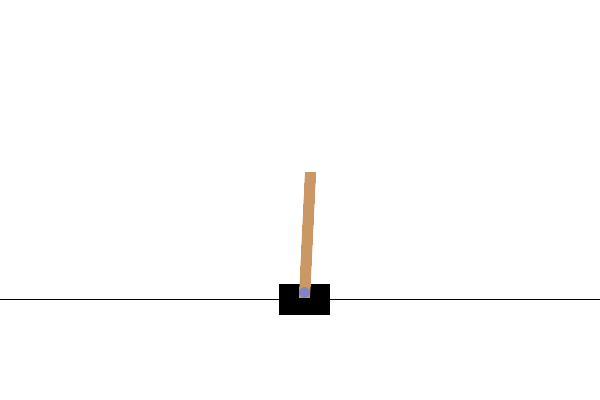

In [ ]:
#@test {"skip": true}
env.reset()
PIL.Image.fromarray(env.render())

The `environment.step` method takes an `action` in the environment and returns a `TimeStep` tuple containing the next observation of the environment and the reward for the action.

The `time_step_spec()` method returns the specification for the `TimeStep` tuple. Its `observation` attribute shows the shape of observations, the data types, and the ranges of allowed values. The `reward` attribute shows the same details for the reward.


In [ ]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [ ]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


The `action_spec()` method returns the shape, data types, and allowed values of valid actions.

In [ ]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


In the Cartpole environment:

-   `observation` is an array of 4 floats:
    -   the position and velocity of the cart
    -   the angular position and velocity of the pole
-   `reward` is a scalar float value
-   `action` is a scalar integer with only two possible values:
    -   `0` — "move left"
    -   `1` — "move right"


In [ ]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([-0.03370193,  0.01198316,  0.04867929, -0.02954268], dtype=float32)})
Next time step:
TimeStep(
{'step_type': array(1, dtype=int32),
 'reward': array(1., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([-0.03346227,  0.20637444,  0.04808844, -0.30647814], dtype=float32)})


Usually two environments are instantiated: one for training and one for evaluation.

In [ ]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

The Cartpole environment, like most environments, is written in pure Python. This is converted to TensorFlow using the `TFPyEnvironment` wrapper.

The original environment's API uses Numpy arrays. The `TFPyEnvironment` converts these to `Tensors` to make it compatible with Tensorflow agents and policies.


In [ ]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agent

The algorithm used to solve an RL problem is represented by an `Agent`. TF-Agents provides standard implementations of a variety of `Agents`, including:

-   [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf) (used in this tutorial)
-   [REINFORCE](https://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)
-   [DDPG](https://arxiv.org/pdf/1509.02971.pdf)
-   [TD3](https://arxiv.org/pdf/1802.09477.pdf)
-   [PPO](https://arxiv.org/abs/1707.06347)
-   [SAC](https://arxiv.org/abs/1801.01290)

The DQN agent can be used in any environment which has a discrete action space.

At the heart of a DQN Agent is a `QNetwork`, a neural network model that can learn to predict `QValues` (expected returns) for all actions, given an observation from the environment.

We will use `tf_agents.networks.` to create a `QNetwork`. The network will consist of a sequence of `tf.keras.layers.Dense` layers, where the final layer will have 1 output for each possible action.

In [ ]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = sequential.Sequential(dense_layers + [q_values_layer])

Now use `tf_agents.agents.dqn.dqn_agent` to instantiate a `DqnAgent`. In addition to the `time_step_spec`, `action_spec` and the QNetwork, the agent constructor also requires an optimizer (in this case, `AdamOptimizer`), a loss function, and an integer step counter.

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

2024-02-16 15:54:01.775740: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


## Policies

A policy defines the way an agent acts in an environment. Typically, the goal of reinforcement learning is to train the underlying model until the policy produces the desired outcome.

In this tutorial:

-   The desired outcome is keeping the pole balanced upright over the cart.
-   The policy returns an action (left or right) for each `time_step` observation.

Agents contain two policies:

-   `agent.policy` — The main policy that is used for evaluation and deployment.
-   `agent.collect_policy` — A second policy that is used for data collection.


In [ ]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

Policies can be created independently of agents. For example, use `tf_agents.policies.random_tf_policy` to create a policy which will randomly select an action for each `time_step`.

In [ ]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

To get an action from a policy, call the `policy.action(time_step)` method. The `time_step` contains the observation from the environment. This method returns a `PolicyStep`, which is a named tuple with three components:

-   `action` — the action to be taken (in this case, `0` or `1`)
-   `state` — used for stateful (that is, RNN-based) policies
-   `info` — auxiliary data, such as log probabilities of actions

In [ ]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))

In [ ]:
time_step = example_environment.reset()

In [ ]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

## Metrics and Evaluation

The most common metric used to evaluate a policy is the average return. The return is the sum of rewards obtained while running a policy in an environment for an episode. Several episodes are run, creating an average return.

The following function computes the average return of a policy, given the policy, environment, and a number of episodes.


In [ ]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

Running this computation on the `random_policy` shows a baseline performance in the environment.

In [ ]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

23.5

## Replay Buffer

In order to keep track of the data collected from the environment, we will use [Reverb](https://deepmind.com/research/open-source/Reverb), an efficient, extensible, and easy-to-use replay system by Deepmind. It stores experience data when we collect trajectories and is consumed during training.

This replay buffer is constructed using specs describing the tensors that are to be stored, which can be obtained from the agent using agent.collect_data_spec.


In [ ]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(
      agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(
    replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
  replay_buffer.py_client,
  table_name,
  sequence_length=2)

[reverb/cc/platform/tfrecord_checkpointer.cc:162]  Initializing TFRecordCheckpointer in /tmpfs/tmp/tmpcvnrrkpg.
[reverb/cc/platform/tfrecord_checkpointer.cc:565] Loading latest checkpoint from /tmpfs/tmp/tmpcvnrrkpg
[reverb/cc/platform/default/server.cc:71] Started replay server on port 46351


For most agents, `collect_data_spec` is a named tuple called `Trajectory`, containing the specs for observations, actions, rewards, and other items.

In [ ]:
agent.collect_data_spec

Trajectory(
{'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32))})

In [ ]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## Data Collection

Now execute the random policy in the environment for a few steps, recording the data in the replay buffer.

Here we are using 'PyDriver' to run the experience collecting loop. You can learn more about TF Agents driver in our [drivers tutorial](https://www.tensorflow.org/agents/tutorials/4_drivers_tutorial).

In [ ]:
#@test {"skip": true}
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'step_type': array(1, dtype=int32),
  'reward': array(1., dtype=float32),
  'discount': array(1., dtype=float32),
  'observation': array([-0.03368392,  0.18694404, -0.00172193, -0.24534112], dtype=float32)}),
 ())

The replay buffer is now a collection of Trajectories.

In [ ]:
# For the curious:
# Uncomment to peel one of these off and inspect it.
# iter(replay_buffer.as_dataset()).next()

The agent needs access to the replay buffer. This is provided by creating an iterable `tf.data.Dataset` pipeline which will feed data to the agent.

Each row of the replay buffer only stores a single observation step. But since the DQN Agent needs both the current and next observation to compute the loss, the dataset pipeline will sample two adjacent rows for each item in the batch (`num_steps=2`).

This dataset is also optimized by running parallel calls and prefetching data.

In [ ]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset

<_PrefetchDataset element_spec=(Trajectory(
{'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'policy_info': (),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None)}), SampleInfo(key=TensorSpec(shape=(64, 2), dtype=tf.uint64, name=None), probability=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), table_size=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), priority=TensorSpec(shape=(64, 2), dtype=tf.float64, name=None), times_sampled=TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)))>

In [ ]:
iterator = iter(dataset)
print(iterator)

In [ ]:
# For the curious:
# Uncomment to see what the dataset iterator is feeding to the agent.
# Compare this representation of replay data
# to the collection of individual trajectories shown earlier.

# iterator.next()

## Training the agent

Two things must happen during the training loop:

-   collect data from the environment
-   use that data to train the agent's neural network(s)

This example also periodicially evaluates the policy and prints the current score.

The following will take ~5 minutes to run.

In [ ]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step.
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

# Reset the environment.
time_step = train_py_env.reset()

# Create a driver to collect experience.
collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
      agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

for _ in range(num_iterations):

  # Collect a few steps and save to the replay buffer.
  time_step, _ = collect_driver.run(time_step)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


[reverb/cc/client.cc:165] Sampler and server are owned by the same process (42980) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (42980) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (42980) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (42980) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (42980) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (42980) so Table uniform_table is accessed directly without gRPC.


I0000 00:00:1703253329.256450   44311 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


step = 200: loss = 168.9337615966797


step = 400: loss = 2.769679069519043


step = 600: loss = 20.378292083740234


step = 800: loss = 2.9951205253601074


step = 1000: loss = 3.985201358795166


step = 1000: Average Return = 41.5


step = 1200: loss = 27.128450393676758


step = 1400: loss = 5.9545087814331055


step = 1600: loss = 30.321374893188477


step = 1800: loss = 4.8639116287231445


step = 2000: loss = 77.69764709472656


step = 2000: Average Return = 189.3000030517578


step = 2200: loss = 38.41033935546875


step = 2400: loss = 73.83688354492188


step = 2600: loss = 89.96795654296875


step = 2800: loss = 318.172119140625


step = 3000: loss = 119.87837219238281


step = 3000: Average Return = 183.1999969482422


step = 3200: loss = 348.0591125488281


step = 3400: loss = 306.32928466796875


step = 3600: loss = 2720.41943359375


step = 3800: loss = 1241.906982421875


step = 4000: loss = 259.3073425292969


step = 4000: Average Return = 177.60000610351562


step = 4200: loss = 411.57086181640625


step = 4400: loss = 96.17520141601562


step = 4600: loss = 293.4364318847656


step = 4800: loss = 115.97804260253906


step = 5000: loss = 135.9969482421875


step = 5000: Average Return = 184.10000610351562


step = 5200: loss = 108.25897216796875


step = 5400: loss = 117.57241821289062


step = 5600: loss = 203.2187957763672


step = 5800: loss = 107.27171325683594


step = 6000: loss = 89.8726806640625


step = 6000: Average Return = 196.5


step = 6200: loss = 719.5379638671875


step = 6400: loss = 671.7078247070312


step = 6600: loss = 605.4098510742188


step = 6800: loss = 118.79557800292969


step = 7000: loss = 1082.111572265625


step = 7000: Average Return = 200.0


step = 7200: loss = 377.11651611328125


step = 7400: loss = 135.56011962890625


step = 7600: loss = 155.7529296875


step = 7800: loss = 162.6855926513672


step = 8000: loss = 160.82798767089844


step = 8000: Average Return = 200.0


step = 8200: loss = 162.89614868164062


step = 8400: loss = 167.7406005859375


step = 8600: loss = 108.040771484375


step = 8800: loss = 545.4006958007812


step = 9000: loss = 176.59364318847656


step = 9000: Average Return = 200.0


step = 9200: loss = 808.9935913085938


step = 9400: loss = 179.5496063232422


step = 9600: loss = 115.72040557861328


step = 9800: loss = 110.83393096923828


step = 10000: loss = 1168.90380859375


step = 10000: Average Return = 200.0


step = 10200: loss = 387.125244140625


step = 10400: loss = 3282.5703125


step = 10600: loss = 4486.83642578125


step = 10800: loss = 5873.224609375


step = 11000: loss = 4588.74462890625


step = 11000: Average Return = 200.0


step = 11200: loss = 233958.21875


step = 11400: loss = 3961.323486328125


step = 11600: loss = 9469.7607421875


step = 11800: loss = 79834.6953125


step = 12000: loss = 6522.5


step = 12000: Average Return = 200.0


step = 12200: loss = 4317.1884765625


step = 12400: loss = 187011.5625


step = 12600: loss = 2300.244873046875


step = 12800: loss = 2199.23193359375


step = 13000: loss = 4176.35888671875


step = 13000: Average Return = 154.10000610351562


step = 13200: loss = 3100.556640625


step = 13400: loss = 114706.8125


step = 13600: loss = 1447.1259765625


step = 13800: loss = 11129.3818359375


step = 14000: loss = 1454.640380859375


step = 14000: Average Return = 200.0


step = 14200: loss = 1165.739990234375


step = 14400: loss = 1011.5919189453125


step = 14600: loss = 1090.4755859375


step = 14800: loss = 1562.9677734375


step = 15000: loss = 1205.5361328125


step = 15000: Average Return = 200.0


step = 15200: loss = 913.7637939453125


step = 15400: loss = 8834.7216796875


step = 15600: loss = 318027.15625


step = 15800: loss = 5136.9150390625


step = 16000: loss = 374743.65625


step = 16000: Average Return = 200.0


step = 16200: loss = 4737.19287109375


step = 16400: loss = 5279.40478515625


step = 16600: loss = 4674.5009765625


step = 16800: loss = 3743.15087890625


step = 17000: loss = 15105.62109375


step = 17000: Average Return = 200.0


step = 17200: loss = 938550.0


step = 17400: loss = 9318.6015625


step = 17600: loss = 10585.978515625


step = 17800: loss = 8195.138671875


step = 18000: loss = 288772.40625


step = 18000: Average Return = 200.0


step = 18200: loss = 6771.6826171875


step = 18400: loss = 3363.34326171875


step = 18600: loss = 611807.75


step = 18800: loss = 6124.15966796875


step = 19000: loss = 1373558.5


step = 19000: Average Return = 200.0


step = 19200: loss = 764662.625


step = 19400: loss = 342950.84375


step = 19600: loss = 10324.072265625


step = 19800: loss = 13140.9892578125


step = 20000: loss = 55873.1328125


step = 20000: Average Return = 200.0


## Visualization


### Plots

Use `matplotlib.pyplot` to chart how the policy improved during training.

One iteration of `Cartpole-v0` consists of 200 time steps. The environment gives a reward of `+1` for each step the pole stays up, so the maximum return for one episode is 200. The charts shows the return increasing towards that maximum each time it is evaluated during training. (It may be a little unstable and not increase monotonically each time.)

(0.08000040054321289, 250.0)

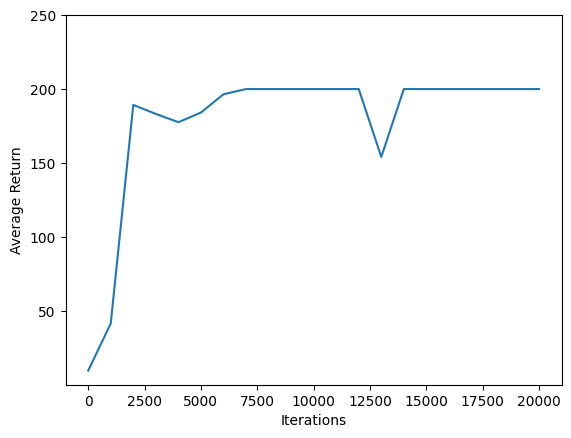

In [ ]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

### Videos

Charts are nice. But more exciting is seeing an agent actually performing a task in an environment.

First, create a function to embed videos in the notebook.

In [ ]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

Now iterate through a few episodes of the Cartpole game with the agent. The underlying Python environment (the one "inside" the TensorFlow environment wrapper) provides a `render()` method, which outputs an image of the environment state. These can be collected into a video.

In [ ]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

[swscaler @ 0x555a5d3cf880] Warning: data is not aligned! This can lead to a speed loss


For fun, compare the trained agent (above) to an agent moving randomly. (It does not do as well.)

In [ ]:
create_policy_eval_video(random_policy, "random-agent")

[swscaler @ 0x55f466934880] Warning: data is not aligned! This can lead to a speed loss
